In [353]:
import pandas as pd
import numpy as np
import os
import re
from quasinet.qnet import Qnet, qdistance, membership_degree, export_qnet_tree,load_qnet, qdistance_matrix, save_qnet
from quasinet.qsampling import qsample, targeted_qsample
import subprocess
EMBED='/home/ishanu/Dropbox/ZED/Research/data_smashing_/bin/embed '
import seaborn as sns
import random
from tqdm import tqdm
from pqdm.processes import pqdm                                                                     
from sklearn import metrics
import pylab as plt
from sklearn.decomposition import PCA


In [2]:
COLSA=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,68,69,70,72,73,78,80,86,87,88,89,90,94,95,96,97,98,99,100,102,103,125,126,127,128,129,130,209,210,211,212,213,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39,40,41,42,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,134,137,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,189,190,191,193,195,196,200,201,202,203,205,206,208,177,183,185,186,187,188]
COLSA=np.array(COLSA).astype(int)-1
len(COLSA)

169

In [3]:
xf=pd.read_csv('cjust/SA.dat',sep=' ',header=None,index_col=0,names=['data'])
pd.DataFrame([list(x[0]) for x in xf.values]).to_csv('cjust/SA.csv',index=None)

In [4]:
xf=pd.read_csv('cjust/JAIL.dat',header=None,names=['data'])
pd.DataFrame([list(x[0]) for x in xf.values]).to_csv('cjust/JAIL.csv',index=None)

In [308]:
jf.index.size

476

In [5]:
jf=pd.read_csv('cjust/JAIL.csv')
jf=jf.astype(str).replace('0','')
Xj = jf.values.astype(str)[:]
Xj

array([['2', '2', '2', ..., '6', '6', '6'],
       ['1', '', '1', ..., '', '', ''],
       ['', '', '2', ..., '', '', ''],
       ...,
       ['', '', '2', ..., '', '', ''],
       ['1', '', '1', ..., '', '', ''],
       ['', '', '2', ..., '', '', '']], dtype='<U1')

In [253]:
pd.DataFrame(jf.replace('',np.nan).count(axis=1)).mean()

0    12.60084
dtype: float64

In [6]:
df=pd.read_csv('cjust/SA.csv')
df=df.iloc[:,COLSA]
df=df.astype(str).replace('0','')

0      2
1      2
2      2
3      2
4      2
      ..
182    6
184    6
185    6
186    6
187    6
Name: 0, Length: 169, dtype: object

In [7]:
X = df.values.astype(str)[:]
X

array([['2', '2', '2', ..., '6', '6', '6'],
       ['2', '2', '1', ..., '1', '1', '1'],
       ['2', '2', '2', ..., '4', '', '1'],
       ...,
       ['1', '1', '1', ..., '', '', ''],
       ['2', '1', '1', ..., '', '', ''],
       ['2', '1', '2', ..., '', '', '']], dtype='<U1')

In [8]:
qnet = Qnet(n_jobs=12,feature_names=df.columns.values).fit(X)

In [318]:
qnetj = Qnet(n_jobs=12,feature_names=df.columns.values).fit(Xj)
save_qnet(qnetj,'cjustJAIL.joblib')

In [9]:
save_qnet(qnet,'cjustSA.joblib')

In [ ]:
qnet=load_qnet('cjustSA.joblib')

In [10]:
out_dirname='./cjust/'
for idx, feature_name in enumerate(qnet.feature_names):
            export_qnet_tree(qnet, idx,
            os.path.join(out_dirname, '{}.dot'.format(feature_name)),
            outformat='graphviz', detailed_output=False)

In [330]:
# test qdistance calculation
seq1 = X[1]
seq2 = Xj[20]

qdist = qdistance(seq1, seq2,qnet,qnet) 
qdistj = qdistance(seq1, seq2,qnet,qnetj) 
qdistjj = qdistance(seq1, seq2,qnetj,qnetj) 
print(qdist,qdistj,qdistjj)

0.25446291295238976 0.7597823277435393 0.02887689168073047


In [355]:
n=475
Nsteps0=100
Nsteps=1000

index1 = np.random.choice(X.shape[0], n, replace=False)  
index2 = np.random.choice(Xj.shape[0], n, replace=False)  
index1a = np.random.choice(X.shape[0], n, replace=False)  


Xj_=Xj[index2]
X_=X[index1]

A=pd.DataFrame(X_).replace('',np.nan).values.astype(float)*(1/((Xj_=='').astype(int)))
A1=pd.DataFrame(A).replace(np.inf,np.nan).fillna('').astype(str)#
X__=A1.replace({'\.0': ''},regex=True).values.astype(str)[:]

X_=X[index1a]
A=pd.DataFrame(X_).replace('',np.nan).values.astype(float)*(1/((Xj_=='').astype(int)))
A1=pd.DataFrame(A).replace(np.inf,np.nan).fillna('').astype(str)#
X__a=A1.replace({'\.0': ''},regex=True).values.astype(str)[:]

 
X_=np.concatenate( (X__, X__a,
                     Xj_), axis=0)

LABEL=np.concatenate((np.zeros(len(index1)),np.zeros(len(index1)),np.ones(len(index2))))

In [332]:
# generate distanec matrix
H=qdistance_matrix(X_,X_, qnetj, qnetj)

pd.DataFrame(H).to_csv('cjust/HMATjj.csv',index=None,header=None,sep=' ')
H.shape

(950, 950)

In [333]:
# calculate sippl embedding

PREF='./cjust/'
FILE='HMATjj.csv'
DATAFILE=PREF+FILE#'data_'
EFILE=PREF+'_Eb1_'
DFILE=PREF+'_Db1_'
PCAEFILE=PREF+'_PEb1_'

In [334]:
STR=EMBED+' -f '+DATAFILE+' -E '+EFILE+' -D '+DFILE
subprocess.call(STR,shell=True);

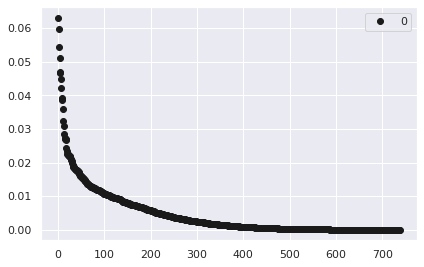

In [335]:
# plot dimensional error
pd.read_csv(DFILE,sep=' ',header=None).transpose().plot(style='ko')

In [336]:
# get embedding matrix
E=pd.read_csv(EFILE,sep=' ',header=None).dropna(axis=1).transpose()
E.columns=['x'+str(i) for i in E.columns]
E.to_csv(PREF+'Eb1.csv')

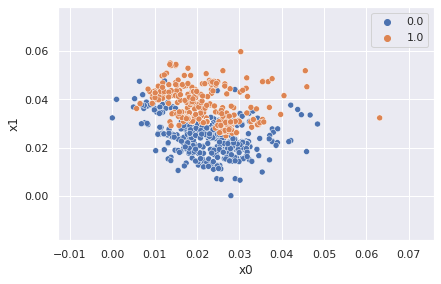

In [337]:
# scatterplot of emedding, colored with DX
sns.scatterplot(E.x0,E.x1,hue=LABEL)

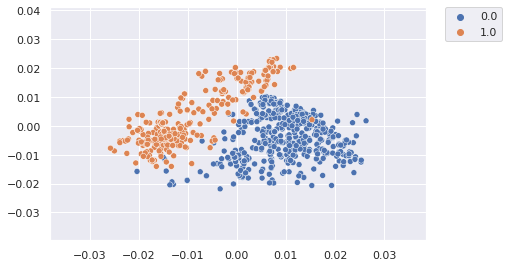

In [338]:
Ef=pd.read_csv(EFILE,sep=' ',header=None).dropna(axis=1).transpose()
Ef.columns=['x'+str(i) for i in Ef.columns]
xf=Ef#.assign(IF=dx.ido)

pca = PCA(n_components=2).fit(xf)
ef=pca.fit_transform(xf)

pd.DataFrame(ef).to_csv(PCAEFILE,header=None,index=None)

sns.scatterplot(x=ef[:,0],y=ef[:,1],hue=LABEL);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

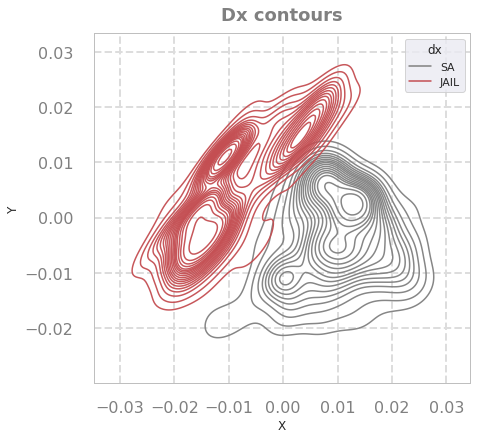

In [339]:
def varname(x):
    if x:
        return 'JAIL'
    return 'SA'
plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=[6,6])
sns.set()

ax=plt.gca()

pf=pd.DataFrame(ef,columns=['X','Y']).assign(ido=LABEL)
pf['dx']=(pf.ido==1)
pf['dx']=[varname(x) for x in pf.dx]
ax=sns.kdeplot(x='X',y='Y',fill=False,data=pf,alpha=.95,lw=2,levels=20,hue='dx',thresh=.05,palette=['.5','r'],fontsize=16)

ax.set_title('Dx contours',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
#plt.setp(ax2.get_yticklabels(), fontsize=16)
#plt.gca().set_xlabel('% reduction in error', fontsize=16,color='.5')
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
##ax.set_xlim(-100,100);
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
#ax.set_ylabel('density',fontsize=16,color='.5',labelpad=10)
#ax.legend(fontsize=16)


plt.savefig('dxcontour_balanced50jj'+'.png',dpi=600,bbox_inches='tight',transparent=True)

In [190]:
# the null response
s_null=['']*len(X[0])
D_null=qnet.predict_distributions(s_null)

In [191]:
def getMaskedSample(s,cols,mutable_vars,
                    mask_prob=0.5,
                    allow_all_mutable=False):
    '''
    Get random masked sample, with mask_prob fraction masked
    '''
    MUTABLE=pd.DataFrame(np.zeros(len(cols)),index=cols).transpose()
    WITHVAL=[x for x in cols[np.where(s)[0]] if x in mutable_vars ]
    MASKrand=[x for x in WITHVAL if random.random() > mask_prob ]
    for m in MASKrand:
        MUTABLE[m]=1.0
            
    mutable_x=MUTABLE.values[0]
    base_frequency=mutable_x/mutable_x.sum()
    
    s1=s.copy()
    for i in range(len(base_frequency)):
        if base_frequency[i]>0.0001:
            s1[i]=''
            
    s_rand=np.copy(s)
    rnd_match_prob=[]        
    max_match_prob=[]        
    D=qnet.predict_distributions(s)
    for i in MASKrand:
        s_rand[np.where(
            cols==i)[0][0]]=choose_one(
                D_null[np.where(cols==i)[0][0]].keys())
        rnd_match_prob=np.append(rnd_match_prob,1/len(
            D_null[np.where(cols==i)[0][0]].keys()))
        max_match_prob=np.append(
            max_match_prob,np.max(
                list(D[np.where(
                    cols==i)[0][0]].values())))
        
    if allow_all_mutable:
        for m in mutable_vars:
            MUTABLE[m]=1.0
        mutable_x=MUTABLE.values[0]
        base_frequency=mutable_x/mutable_x.sum()

    return s1,base_frequency,MASKrand,np.where(
        base_frequency)[0],np.mean(rnd_match_prob),np.mean(max_match_prob),s_rand

def choose_one(X):
    X=list(X)
    if len(X)>0:
        return X[np.random.randint(len(X))]
    return None

samples=None
def getRecon(index,MEAN=True):
    s=samples[index]
    
    s1,bp,mask_,maskindex,rmatch_u,rmatch,s_rand=getMaskedSample(s,cols,
                                                                     mutable_vars,
                                                                     mask_prob=MASKPROB)
    qs=qsample(s1,qnet,Nsteps,bp)
    recondf=pd.DataFrame([s,qs,s_rand],columns=cols,index=['s','q','r'])[mask_].transpose()
    recondf=recondf.replace('',np.nan).dropna(axis=0).astype(float)
    recondf['delta']=recondf.s-recondf.q
    if MEAN:
        return recondf.delta.mean()
    return recondf

In [161]:
# Reconstruction parameters

cols=qnet.feature_names
mutable_vars=cols
MASKPROB=.018
Nsteps=12000

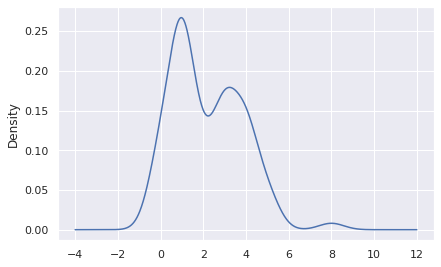

In [162]:
samples=X
#getDissonance(0)

getRecon(0,MEAN=False).delta.plot.kde()

In [163]:
samples=X_
Recon=pqdm(range(len(X_)), getRecon, n_jobs=12)                                                              
DF=pd.DataFrame(Recon,columns=['recon'])
DF
DF.to_csv(PREF+'Recon3.csv')
DF=pd.read_csv(PREF+'Recon3.csv',index_col=0)
#DF=DF.join(df.PTSDDx.reset_index()).set_index('record_id')

AttributeError: 'DataFrame' object has no attribute 'PTSDDx'

In [ ]:
#print(DF[DF.PTSDDx==1].recon.mean(),DF[DF.PTSDDx==0].recon.mean())

In [ ]:
plt.figure(figsize=[20,6])
plt.style.use('fivethirtyeight')
plt.subplot(2,1,1)
plt.subplots_adjust(hspace=.5)
DF.iloc[:len(index1),:].recon.plot(kind='bar',color='r')
plt.gca().set_xlabel('')
ax0=plt.gca()
plt.subplot(2,1,2)
DF.iloc[len(index1):,:].recon.plot(kind='bar',color='k')
ax=plt.gca()
#plt.setp(ax.get_xticklabels(), fontsize=10);
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax0.set_title('mean reconstruction error',fontsize=20,fontweight='bold');
ax0.legend(['positive'],fontsize=18)
ax.legend(['control'],fontsize=18)

plt.savefig(PREF+'recosntruction_3_balanced1'+'.png',dpi=600,bbox_inches='tight',transparent=True)

## conclusions
+ we achieve small reconstruction error with a very few items revealed (2.5% ie 5)

In [47]:
def getDissonance(sample_index,index=None,MISSING_VAL=np.nan):                                  
    '''                                                                                               
    Dissonnace vector                                                                                                   
    '''  
    if isinstance(sample_index, int):
        s=samples[sample_index]                                                                           
    else:
        s=sample_index
    if index is None:                                                                                 
        index=range(len(s))                                                                           
                                                                                                      
    Ds=qnet.predict_distributions(s)                                                                  
                                                                                                      
    diss=np.ones(len(Ds))*MISSING_VAL                                                                 
    for i in index:                                                                                   
        if s[i] != '':                                                                                
            if s[i] in Ds[i].keys():                                                                  
                diss[i]=1-Ds[i][s[i]]/np.max(                                                         
                    list(Ds[i].values()))                                                             
            else:                                                                                     
                diss[i]=1.0                                                                           
                                                                                                      
    return diss                                                                        

In [48]:
samples=X
from pqdm.processes import pqdm                                                                     
Diss=pqdm(range(len(X)), getDissonance, n_jobs=12)                                                              
Diss=pd.DataFrame(Diss)

In [49]:
Diss

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,168
0,0.000000,0.000000,0.132474,0.354631,0.141257,0.000000,0.742338,0.075538,0.856074,0.453560,...,0.889283,0.119073,0.584074,0.982306,0.760433,0.839609,0.938249,0.969268,0.977821,0.989853
1,0.000000,0.168590,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.712532,0.643405,...,0.000000,0.203042,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.430947,0.000000,0.436082,0.000000,0.721008,0.461465,0.000000,0.759459,...,0.877883,0.000000,0.000000,0.000000,0.000000,0.674041,0.786087,0.784054,NaN,0.000000
3,0.000000,0.420499,0.837435,0.838782,0.000000,0.000000,0.000000,0.000000,0.812577,0.639608,...,0.876505,0.690580,0.598335,0.991799,0.000000,0.911587,0.901356,0.835104,0.964892,0.989550
4,0.000000,0.000000,0.680366,0.000000,0.505537,0.000000,0.752095,0.177092,0.858198,0.809590,...,0.000000,0.654411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,0.000000,0.454392,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.811310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1023,0.000000,0.000000,0.275795,0.000000,0.000000,0.000000,0.729726,0.154871,0.776430,0.331001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1024,0.626609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.861265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1025,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
samples=Xj
from pqdm.processes import pqdm                                                                     
Dissj=pqdm(range(len(Xj)), getDissonance, n_jobs=12)                                                              
Dissj=pd.DataFrame(Dissj)

In [51]:
Dissj

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,168
0,0.000000,0.0,0.132474,0.354631,0.141257,0.0,0.742338,0.075538,0.856074,0.45356,...,0.889283,0.119073,0.584074,0.982306,0.760433,0.839609,0.938249,0.969268,0.977821,0.989853
1,0.174059,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.531114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.174059,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472,NaN,NaN,0.948276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473,NaN,NaN,0.947887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474,0.174059,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
# generate random responses
Xrand=[(np.random.randint(5,size=len(X[0]))+1).astype(str) for i in range(100)]

In [71]:
# compute dissonance for random responses
samples=Xrand
from pqdm.processes import pqdm                                                                     
Dissrand=pqdm(range(len(Xrand)), getDissonance, n_jobs=12)                                                              
Dissrand=pd.DataFrame(Dissrand)

0.2995872932481531 0.18308203869040007


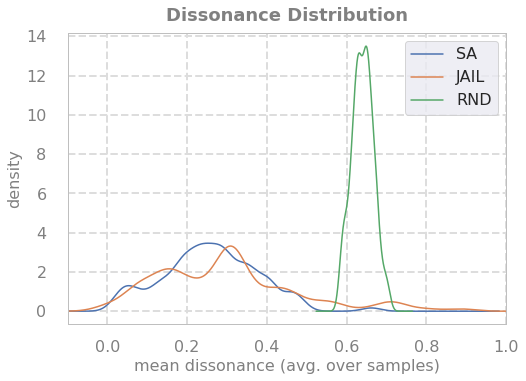

In [216]:
print(Dissj.mean(axis=1).mean(),Dissj.mean(axis=1).std())

fig=plt.figure(figsize=[7,5])
sns.set()

ax=plt.gca()


#Dissj.mean(axis=1).plot.kde(bw_method=0.25,lw=3,label='JAIL')
#Diss.mean(axis=1).plot.kde(ax=ax,bw_method=0.25,lw=3,label='SA')
DS=pd.DataFrame(Diss.mean(axis=1),columns=['SA']).join(pd.DataFrame(Dissj.mean(axis=1),columns=['JAIL'])).join(pd.DataFrame(Dissrand.mean(axis=1),columns=['RND']))

DSTD=pd.DataFrame(Diss.std(axis=1),columns=['SA']).join(
    pd.DataFrame(Dissj.std(axis=1),columns=['JAIL'])).join(
    pd.DataFrame(Dissrand.std(axis=1),columns=['RND']))

DS=DS.join(DSTD,rsuffix='_std').dropna()

DS=DS.assign(delta=DS.SA-DS.JAIL)


ax=DS.SA.plot.kde(bw_method=.2)
DS.JAIL.plot.kde(ax=ax,bw_method=.2)
DS.RND.plot.kde(ax=ax,bw_method=.3)
ax.set_xlim(-.1,1)


ax.set_title('Dissonance Distribution',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
#plt.gca().set_xlim(-.1,.4)
ax.set_ylabel('density',fontsize=16,color='.5')
ax.set_xlabel('mean dissonance (avg. over samples)',fontsize=16,color='.5')
ax.legend(fontsize=16)

plt.savefig(PREF+'dissonance_dist'+'.png',dpi=600,bbox_inches='tight',transparent=True)

0.5959091548171902


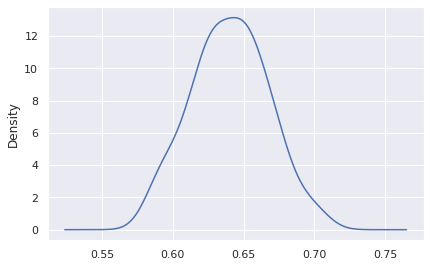

In [236]:
# determine threshold
Dissrand.mean(axis=1).plot.kde()
mRND=Dissrand.mean(axis=1).mean()
sRND=Dissrand.mean(axis=1).std(ddof=1)
from scipy import stats

# alpha to critical
alpha = 0.05
n_sided = 1 # 2-sided test
z_crit = stats.norm.ppf(1-alpha/n_sided)

# critical to alpha
#alpha = stats.norm.sf(z_crit) * n_sided
#print(alpha) # 0.05

threshold=(-z_crit*sRND)+mRND
print(threshold)

476 34
0    0.661849
dtype: float64


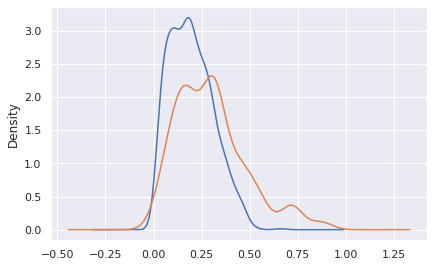

In [241]:
Diss.mean(axis=1).plot.kde()
Dissj.mean(axis=1).plot.kde()
TH=threshold

mDissj=Dissj.mean(axis=1).sort_values(ascending=False)
print(mDissj.index.size,mDissj[mDissj>TH].index.size)
mDiss=Diss.mean(axis=1).sort_values(ascending=False)
print(mDiss[mDiss>TH])


In [128]:
print(Dissj.mean(axis=1).mean(),Dissj.mean(axis=1).std())




#Dissj.mean(axis=1).plot.kde(bw_method=0.25,lw=3,label='JAIL')
#Diss.mean(axis=1).plot.kde(ax=ax,bw_method=0.25,lw=3,label='SA')
DS=pd.DataFrame(Diss.mean(axis=0),columns=['SA']).join(
    pd.DataFrame(Dissj.mean(axis=0),columns=['JAIL'])).join(
    pd.DataFrame(Dissrand.mean(axis=0),columns=['RND']))
DSTD=pd.DataFrame(Diss.std(axis=0),columns=['SA']).join(
    pd.DataFrame(Dissj.std(axis=0),columns=['JAIL'])).join(
    pd.DataFrame(Dissrand.std(axis=0),columns=['RND']))
DSn=pd.DataFrame(Diss.count(axis=0),columns=['SA']).join(
    pd.DataFrame(Dissj.count(axis=0),columns=['JAIL'])).join(
    pd.DataFrame(Dissrand.count(axis=0),columns=['RND']))



DS=DS.assign(delta=DS.SA-DS.JAIL)

0.2995872932481531 0.18308203869040007


In [130]:
DSs=DS.join(DSTD,rsuffix='_std').join(DSn,rsuffix='_n').dropna()
DSs.SA_std=DSs.SA_std/np.sqrt(DSs.SA_n)
DSs.JAIL_std=DSs.JAIL_std/np.sqrt(DSs.JAIL_n)
DSs.RND_std=DSs.RND_std/np.sqrt(DSs.RND_n)
DSs

,SA,JAIL,RND,delta,SA_std,JAIL_std,RND_std,SA_n,JAIL_n,RND_n
0,0.087542,0.140488,0.807192,-0.052946,0.007626,0.017600,0.038119,1015,166,100
2,0.212351,0.284472,0.702066,-0.072121,0.010339,0.018660,0.041459,1015,476,100
4,0.131427,0.047086,0.731912,0.084341,0.007643,0.047086,0.040260,1015,3,100
20,0.051634,0.151566,0.841260,-0.099932,0.009682,0.016214,0.035535,514,476,100
21,0.140105,0.112225,0.740047,0.027880,0.014893,0.013809,0.041772,514,476,100
23,0.225381,0.148038,0.729077,0.077342,0.017651,0.015353,0.040094,514,476,100
25,0.129123,0.265092,0.814769,-0.135969,0.014601,0.019397,0.037068,514,476,100
31,0.125031,0.444488,0.831787,-0.319457,0.010600,0.035120,0.036597,909,150,100
32,0.105200,0.673998,0.822451,-0.568797,0.009681,0.143877,0.037440,910,3,100
33,0.044305,0.549451,0.770380,-0.505147,0.006640,0.079545,0.040710,910,31,100


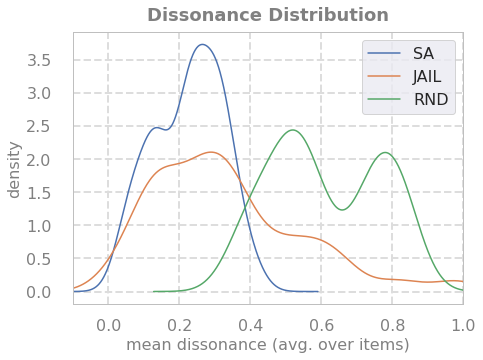

In [131]:
fig=plt.figure(figsize=[7,5])
sns.set()

ax=plt.gca()

ax=DSs.SA.plot.kde(bw_method=.4)

#(DSs.SA+DSs.SA_std).plot.kde(ax=ax,color='.8',bw_method=.4)
#(DSs.SA-DSs.SA_std).plot.kde(ax=ax,color='.8',bw_method=.4)


DSs.JAIL.plot.kde(ax=ax,bw_method=.3)
#(DSs.JAIL+DSs.JAIL_std).plot.kde(ax=ax,color='.8',bw_method=.2)
#(DSs.JAIL-DSs.JAIL_std).plot.kde(ax=ax,color='.8',bw_method=.2)

DSs.RND.plot.kde(ax=ax,bw_method=.4)
#(DSs.RND+DSs.RND_std).plot.kde(ax=ax,color='.8',bw_method=.4)
#(DSs.RND-DSs.RND_std).plot.kde(ax=ax,color='.8',bw_method=.4)
ax.set_xlim(-.1,1)




ax.set_title('Dissonance Distribution',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
#plt.gca().set_xlim(-.1,.4)
ax.set_ylabel('density',fontsize=16,color='.5')
ax.set_xlabel('mean dissonance (avg. over items)',fontsize=16,color='.5')
ax.legend(fontsize=16)

plt.savefig(PREF+'dissonance_dist_items_nonnan'+'.png',dpi=600,bbox_inches='tight',transparent=True)

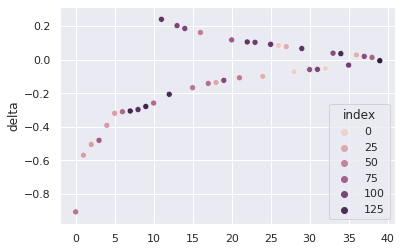

In [136]:
DD=DSs.assign(deltaabs=np.abs(DSs.delta)).sort_values('deltaabs',ascending=False).reset_index()
#DD=DD[DD.deltaabs>0.4]
sns.scatterplot(y='delta',x=DD.index,data=DD,hue='index')

In [138]:
DD[DD.delta<-.35]

,index,SA,JAIL,RND,delta,SA_std,JAIL_std,RND_std,SA_n,JAIL_n,RND_n,deltaabs
0,62,0.073597,0.980042,0.815294,-0.906445,0.009052,0.012945,0.036557,814,4,100,0.906445
1,32,0.105200,0.673998,0.822451,-0.568797,0.009681,0.143877,0.037440,910,3,100,0.568797
2,33,0.044305,0.549451,0.770380,-0.505147,0.006640,0.079545,0.040710,910,31,100,0.505147
3,79,0.338401,0.818970,0.637811,-0.480568,0.011090,0.020711,0.033996,1026,73,100,0.480568
4,34,0.066679,0.457301,0.744426,-0.390622,0.008165,0.077415,0.042073,909,35,100,0.390622


In [196]:
DD[DD.delta>.15]

,index,SA,JAIL,RND,delta,SA_std,JAIL_std,RND_std,SA_n,JAIL_n,RND_n,deltaabs
11,116,0.253902,0.013625,0.434439,0.240277,0.013487,0.008023,0.030777,402,71,100,0.240277
13,98,0.320735,0.118242,0.569681,0.202493,0.010148,0.013543,0.034642,1014,294,100,0.202493
14,100,0.274133,0.088676,0.365764,0.185458,0.009113,0.023562,0.028976,1014,86,100,0.185458
16,54,0.276708,0.115067,0.752548,0.161641,0.018405,0.063587,0.040602,511,24,100,0.161641


In [210]:
X[:][239].astype(int)#.mean()

array([2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 4, 3, 2, 3, 4, 2, 1, 4, 1, 1, 2, 2, 2, 2, 4, 1, 2, 2, 1, 2, 1,
       3, 3, 2, 4, 2, 4, 5, 4, 1, 1, 1, 4, 2, 2, 1, 1, 1, 1, 2, 1, 1, 4,
       2, 1, 5, 1, 2, 2, 2, 4, 4, 2, 2, 2, 1, 4, 3, 4, 2, 1, 2, 2, 1, 4,
       4, 7, 9, 7, 5, 7, 2, 3, 1, 3, 3, 3, 1, 1, 1, 4, 3, 2, 6, 1, 1, 6,
       2, 1, 1, 1, 6, 5, 4, 1, 1, 1, 2, 1, 1, 1, 1])

In [215]:
Xj[0]

array(['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '4', '2', '2', '2', '2', '4', '4', '4', '5', '5', '5',
       '5', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '4', '4', '4', '4', '4', '4', '2', '4', '4', '4',
       '2', '2', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '4', '4', '4', '4', '4', '2', '2', '2', '2', '5', '5', '5',
       '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5',
       '5', '5', '5', '5', '2', '5', '5', '5', '5', '5', '5', '5', '5',
       '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '2',
       '2', '5', '5', '9', '9', '9', '9', '9', '5', '5', '5', '5', '5',
       '5', '5', '5', '5', '5', '5', '5', '6', '6', '6', '6', '6', '6',
       '6', '6', '6', '6', '5', '5', '5', '2', '6', '6', '6', '6', '6'],
      dtype='<U1')

In [197]:
COLSA[DD[DD.delta>.15]['index'].values]

array([239,  54,  56, 221])

In [142]:
COLSA[DD[DD.delta<-.35]['index'].values]

array([229,  98,  99,  29, 101])

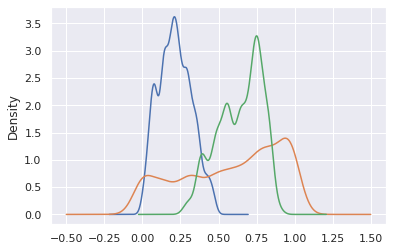

In [77]:
DS=pd.DataFrame(Dissrand.mean(axis=0),columns=['RND']).join(DS)
#DS=DS.assign(delta=DS.SA-DS.JAIL)
ax=DS.SA.plot.kde(bw_method=.2)
DS.JAIL.plot.kde(ax=ax,bw_method=.2)
DS.RND.plot.kde(ax=ax,bw_method=.2)
#ax.set_xlim(-0,1.05)

,RND,SA,JAIL,delta
0,0.807192,0.087542,0.140488,-0.052946
1,0.623018,0.085105,0.000000,0.085105
2,0.702066,0.212351,0.284472,-0.072121
3,0.639066,0.212988,0.354631,-0.141644
4,0.731912,0.131427,0.047086,0.084341
...,...,...,...,...
164,0.566640,0.365785,0.839609,-0.473824
165,0.655777,0.285555,0.938249,-0.652694
166,0.653697,0.411744,0.969268,-0.557524
167,0.725347,0.262550,0.977821,-0.715271


In [ ]:
samples=Xrand
Reconrand=pqdm(range(len(Xrand)), getRecon, n_jobs=12)                                                              

In [ ]:
DF=pd.DataFrame(Recon,columns=['recon'])
DFrand=pd.DataFrame(Reconrand,columns=['recon_random'])
ax=DFrand.plot.kde()
DF.plot.kde(ax=ax)

In [ ]:
import seaborn as sns
labels = DF1.PTSDDx.values
lut = dict(zip(set(labels), ['.5','red']))
row_colors = pd.DataFrame(labels)[0].map(lut)

cm=sns.clustermap(Diss,method='ward',row_colors=row_colors,cmap='viridis')
cm.ax_heatmap.set_xlabel('Items',fontsize=24,labelpad=20)
cm.ax_heatmap.set_ylabel('Respondants',fontsize=24,labelpad=10)
print(set(labels))

plt.savefig('clsmap_balanced1'+'.png',dpi=600,bbox_inches='tight',transparent=True)

In [ ]:
#sns.scatterplot(E.x0,E.x1,hue=DS.diss,cmap='jet')
plt.style.use('fivethirtyeight')
plt.scatter(E.x0,E.x1,c=DF1.dissonance,cmap='jet',s=2**(3*(DF1.PTSDDx+1)),alpha=.5)

In [ ]:
fig=plt.figure(figsize=[7,6])
sns.set()

ax=plt.gca()

fpr, tpr, thresholds = metrics.roc_curve(DF1.PTSDDx.values,DF1.dissonance, pos_label=1)
print(metrics.auc(fpr, tpr))

fpr1, tpr1, thresholds1 = metrics.roc_curve(DF1.PTSDDx.values,DF1.recon, pos_label=1)
print(metrics.auc(fpr1, tpr1))

plt.plot(fpr,tpr,lw=2,label='dissonance')
plt.plot(fpr1,tpr1,lw=2,label='recon error')
plt.gca().legend()
plt.gca().set_xlim(-0.01,1.02)
plt.gca().set_ylim(-0.01,1.02)

ax.set_title('ROC curves',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
plt.gca().set_ylim(-0.01,1.02)
plt.gca().set_xlim(-0.01,1.02)
ax.set_ylabel('TPR',fontsize=16,color='.5')
ax.set_xlabel('FPR',fontsize=16,color='.5')
ax.legend(['Dissonance','Reconstruction Error'],fontsize=16)

plt.savefig('ROC_balanced1'+'.png',dpi=600,bbox_inches='tight',transparent=True)

In [ ]:
fig=plt.figure(figsize=[7,5])
sns.set()

ax=plt.gca()

#DF1.plot.scatter(ax=ax,x='dissonance',y='recon',cmap='seismic',c='PTSDDx')
sns.scatterplot(ax=ax,x='dissonance',y='recon',cmap='seismic',hue='PTSDDx',data=DF1)

ax.set_title('Mean Dissonance vs Mean Reconstruction Error',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
plt.gca().set_ylim(-1.45,1.95)
plt.gca().set_xlim(0.05,.5)
ax.set_ylabel('mean reconstruction error',fontsize=16,color='.5')
ax.set_xlabel('mean dissonance',fontsize=16,color='.5')
#ax.legend(fontsize=16)

print(Dissrand.mean(axis=1).mean(),Dissrand.mean(axis=1).std())

plt.plot(Dissrand.mean(axis=1).mean()*np.array([1,1]),[-1.45,1.95],'-r')
plt.plot((Dissrand.mean(axis=1).mean()-Dissrand.mean(axis=1).std())*np.array([1,1]),[-1.45,1.95],'--r')
plt.plot((Dissrand.mean(axis=1).mean()+Dissrand.mean(axis=1).std())*np.array([1,1]),[-1.45,1.95],'--r')

ax.text(s='random response',x=.44,y=-0.50,rotation=90,fontsize=16,color='r')

plt.savefig('dissrecon_balanced1'+'.png',dpi=600,bbox_inches='tight',transparent=True)





In [ ]:
DF1.sort_values('dissonance',ascending=False).head()